# Notebook 1 : Préparation des Données

**Trash Hero - Tri Intelligent des Déchets par IA**

Dans ce notebook, nous allons :
1. Télécharger et explorer le dataset de déchets
2. Organiser les données en train/validation/test
3. Visualiser la distribution des classes
4. Créer des DataLoaders PyTorch

## 1.1 Imports et Configuration

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
from PIL import Image

# Import des fonctions utilitaires
import sys
sys.path.append('..')
from utils import *

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

Device: cuda
CUDA disponible: True


## 1.2 Configuration des Chemins


In [20]:
# Chemins du projet
PROJECT_ROOT = Path('..').resolve()
DATA_ROOT = PROJECT_ROOT / 'data'

# Dataset brut téléchargé depuis Kaggle
RAW_DATA_DIR = DATA_ROOT / 'raw' / 'garbage-classification'

# Dataset organisé en train/val/test
PROCESSED_DATA_DIR = DATA_ROOT / 'processed'

# Créer les dossiers s'ils n'existent pas
DATA_ROOT.mkdir(parents=True, exist_ok=True)
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)

print(f"Dossier du projet: {PROJECT_ROOT.absolute()}")
print(f"Dossier des données: {DATA_ROOT.absolute()}")
print(f"Dataset brut: {RAW_DATA_DIR.absolute()}")
print(f"Dataset traité: {PROCESSED_DATA_DIR.absolute()}")

Dossier du projet: C:\Users\Asus\Desktop\trash-hero
Dossier des données: C:\Users\Asus\Desktop\trash-hero\data
Dataset brut: C:\Users\Asus\Desktop\trash-hero\data\raw\garbage-classification
Dataset traité: C:\Users\Asus\Desktop\trash-hero\data\processed


## 1.3 Téléchargement du Dataset
https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification


## 1.4 Exploration du Dataset

In [21]:
# Vérifier que le dataset existe
if not RAW_DATA_DIR.exists():
    print("Le dataset n'a pas été trouvé!")
    print(f"Veuillez télécharger et dézipper le dataset dans: {RAW_DATA_DIR}")
else:
    print("Dataset trouvé!")

    # Lister les classes
    classes = [d.name for d in RAW_DATA_DIR.iterdir() if d.is_dir()]
    print(f"\n Classes détectées ({len(classes)}):")
    for cls in sorted(classes):
        print(f"  - {cls}")

Dataset trouvé!

 Classes détectées (6):
  - cardboard
  - glass
  - metal
  - paper
  - plastic
  - trash


## 1.5 Comptage des Images par Classe


Distribution des images:
cardboard       :  403 images
glass           :  501 images
metal           :  410 images
paper           :  594 images
plastic         :  482 images
trash           :  137 images
TOTAL           : 2527 images



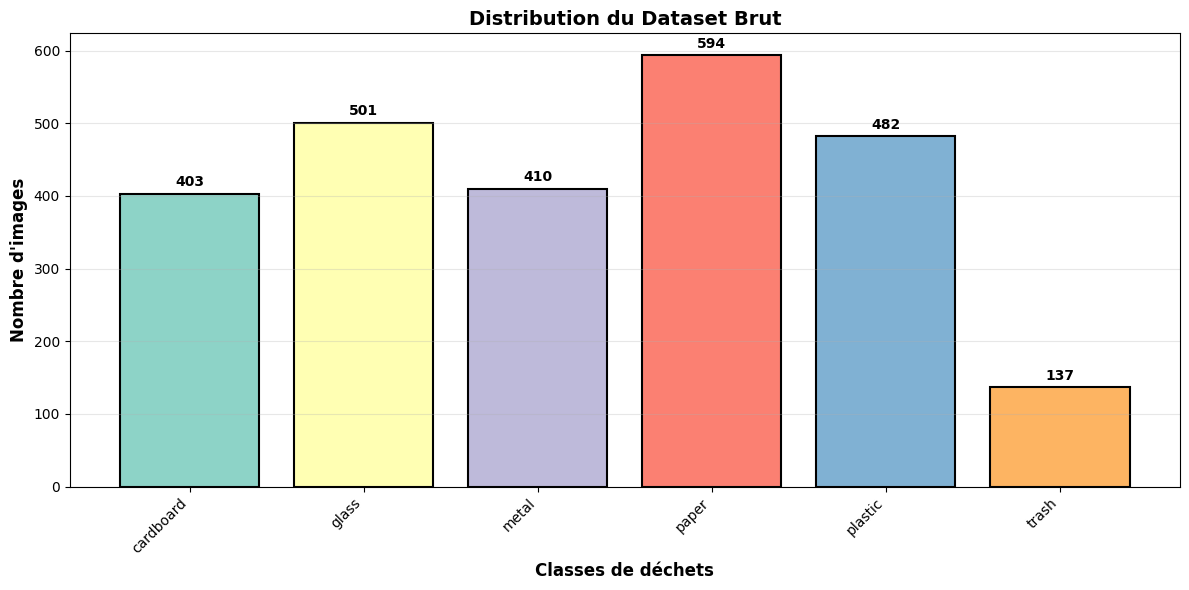

In [22]:
# Compter les images par classe
class_counts = count_images_per_class(RAW_DATA_DIR)

print("\nDistribution des images:")
print("="*50)
for cls, count in sorted(class_counts.items()):
    print(f"{cls:15s} : {count:4d} images")
print("="*50)
print(f"{'TOTAL':15s} : {sum(class_counts.values()):4d} images\n")

# Visualiser la distribution
plot_class_distribution(class_counts, "Distribution du Dataset Brut")

## 1.6 Visualisation d'Exemples d'Images

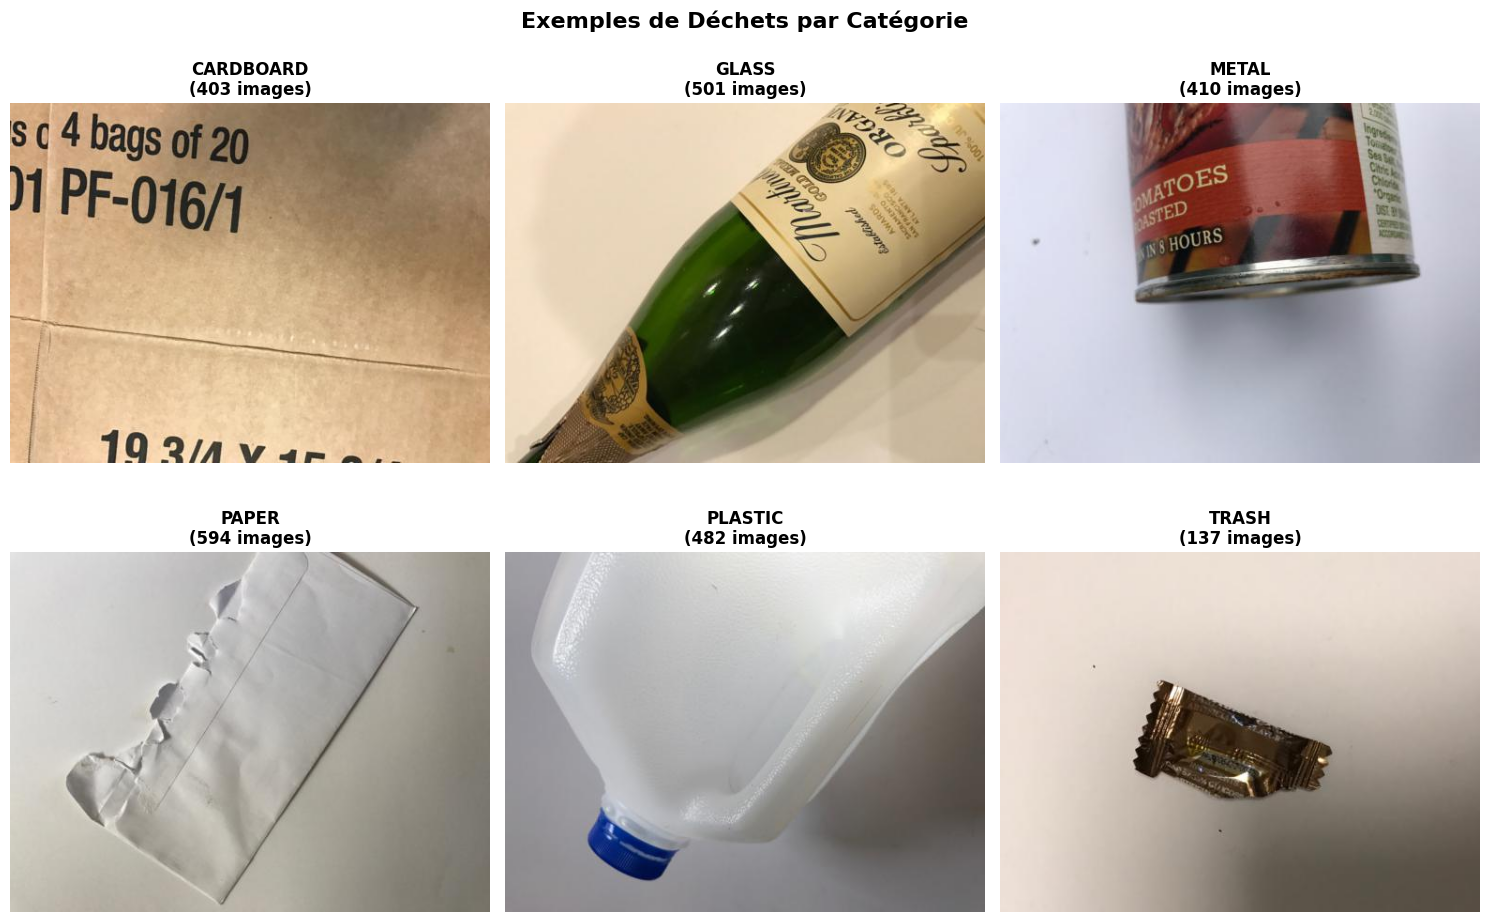

In [23]:
# Afficher quelques exemples par classe
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (cls, ax) in enumerate(zip(sorted(classes), axes)):
    class_dir = RAW_DATA_DIR / cls
    images = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))

    if images:
        img_path = np.random.choice(images)
        img = Image.open(img_path)

        ax.imshow(img)
        ax.set_title(f"{cls.upper()}\n({len(images)} images)",
                    fontsize=12, fontweight='bold')
        ax.axis('off')

plt.suptitle('Exemples de Déchets par Catégorie',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.7 Split Train/Validation/Test

Nous allons diviser le dataset en :
- **70% Train** : Pour l'entraînement
- **15% Validation** : Pour valider pendant l'entraînement
- **15% Test** : Pour l'évaluation finale

In [24]:
# Organisation du dataset
print("Organisation du dataset en train/valid/test...\n")

organize_dataset(
    source_dir=RAW_DATA_DIR,
    dest_dir=PROCESSED_DATA_DIR,
    split_ratios={'train': 0.70, 'valid': 0.15, 'test': 0.15}
)

print("\nDataset organisé avec succès!")

Organisation du dataset en train/valid/test...

cardboard: 282 train, 60 valid, 61 test
glass: 350 train, 75 valid, 76 test
metal: 287 train, 61 valid, 62 test
paper: 415 train, 89 valid, 90 test
plastic: 337 train, 72 valid, 73 test
trash: 95 train, 20 valid, 22 test

Dataset organisé avec succès!


## 1.8 Vérification du Split

In [25]:
# Vérifier les splits
for split in ['train', 'valid', 'test']:
    split_dir = PROCESSED_DATA_DIR / split
    split_counts = count_images_per_class(split_dir)

    print(f"\n{split.upper()} SET:")
    print("="*50)
    for cls, count in sorted(split_counts.items()):
        print(f"{cls:15s} : {count:4d} images")
    print("="*50)
    print(f"{'TOTAL':15s} : {sum(split_counts.values()):4d} images")


TRAIN SET:
cardboard       :  392 images
glass           :  474 images
metal           :  367 images
paper           :  532 images
plastic         :  441 images
trash           :  125 images
TOTAL           : 2331 images

VALID SET:
cardboard       :  159 images
glass           :  139 images
metal           :  114 images
paper           :  164 images
plastic         :  133 images
trash           :   37 images
TOTAL           :  746 images

TEST SET:
cardboard       :  154 images
glass           :  140 images
metal           :  111 images
paper           :  165 images
plastic         :  132 images
trash           :   42 images
TOTAL           :  744 images


## 1.9 Création des Transforms et DataLoaders

In [26]:
# Paramètres
IMG_SIZE = 224
BATCH_SIZE = 32

# Transforms pour train (avec augmentation basique)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Transforms pour validation et test (sans augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("Transforms créés")

Transforms créés


In [27]:
# Créer les datasets
train_dataset = ImageFolder(PROCESSED_DATA_DIR / 'train', transform=train_transforms)
valid_dataset = ImageFolder(PROCESSED_DATA_DIR / 'valid', transform=eval_transforms)
test_dataset = ImageFolder(PROCESSED_DATA_DIR / 'test', transform=eval_transforms)

# Créer les dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Récupérer les noms de classes
class_names = train_dataset.classes
n_classes = len(class_names)

print(f"\nDataLoaders créés")
print(f"\nStatistiques:")
print(f"  - Classes: {class_names}")
print(f"  - Nombre de classes: {n_classes}")
print(f"  - Images train: {len(train_dataset)}")
print(f"  - Images valid: {len(valid_dataset)}")
print(f"  - Images test: {len(test_dataset)}")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Batches train: {len(train_loader)}")


DataLoaders créés

Statistiques:
  - Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
  - Nombre de classes: 6
  - Images train: 2331
  - Images valid: 746
  - Images test: 744
  - Batch size: 32
  - Batches train: 73


## 1.10 Test du DataLoader

In [28]:
# Tester le dataloader
batch_images, batch_labels = next(iter(train_loader))

print(f"\nTest du DataLoader:")
print(f"  - Shape du batch d'images: {batch_images.shape}")
print(f"  - Shape du batch de labels: {batch_labels.shape}")
print(f"  - Device: {batch_images.device}")
print(f"  - Min pixel value: {batch_images.min():.3f}")
print(f"  - Max pixel value: {batch_images.max():.3f}")


Test du DataLoader:
  - Shape du batch d'images: torch.Size([32, 3, 224, 224])
  - Shape du batch de labels: torch.Size([32])
  - Device: cpu
  - Min pixel value: -2.118
  - Max pixel value: 2.640


## 1.11 Visualisation d'un Batch

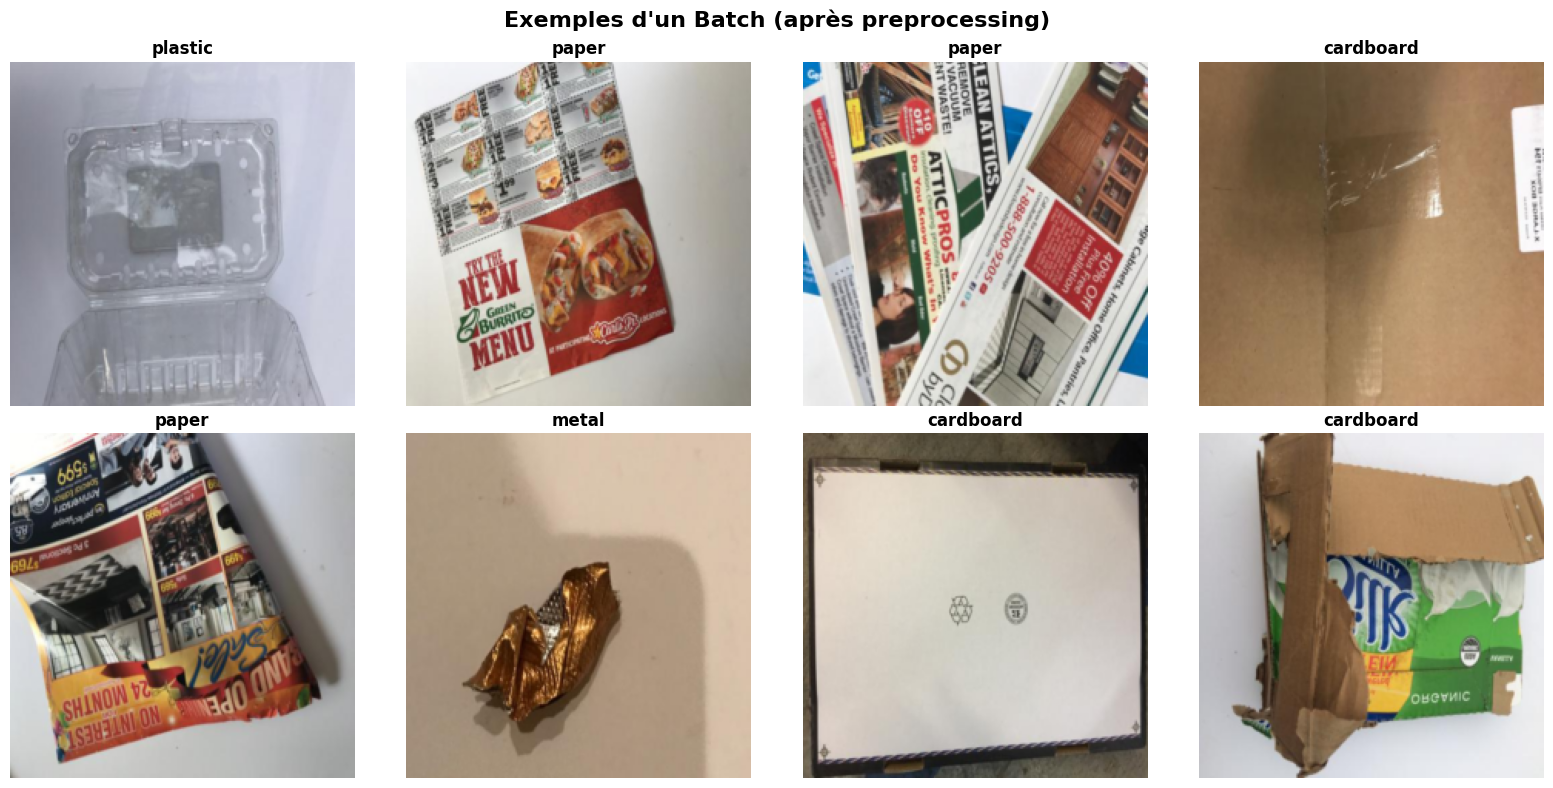

In [32]:
# Fonction pour dénormaliser les images
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Visualiser un batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx in range(8):
    img = denormalize(batch_images[idx]).permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    label_idx = batch_labels[idx].item()
    label_name = class_names[label_idx]

    axes[idx].imshow(img)
    axes[idx].set_title(f"{label_name}", fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Exemples d\'un Batch (après preprocessing)',
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 1.12 Sauvegarde des Informations

In [33]:
# Sauvegarder les informations importantes
import json

data_info = {
    'n_classes': n_classes,
    'class_names': class_names,
    'img_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'n_train': len(train_dataset),
    'n_valid': len(valid_dataset),
    'n_test': len(test_dataset)
}

with open(DATA_ROOT / 'data_info.json', 'w') as f:
    json.dump(data_info, f, indent=4)

print("Informations sauvegardées dans data/data_info.json")

Informations sauvegardées dans data/data_info.json


##  Résumé

Dans ce notebook, nous avons :

1. Téléchargé et exploré le dataset de déchets
2. Organisé les données en train/validation/test (70/15/15)
3. Créé des transforms PyTorch avec normalisation
4. Créé des DataLoaders efficaces
5. Visualisé la distribution et des exemples

###  Prochaine étape

**Notebook 2** : Créer et entraîner un CNN de base (baseline)